In [19]:
%load_ext nb_black
import pandas as pd
from pyarrow.parquet import ParquetFile
import dask.dataframe as dd
import os
import xarray as xr
import ujson
import pprint

<IPython.core.display.Javascript object>

In [20]:
# These fs options don't work for http... beware!
so = dict(mode="rb", anon=True, default_fill_cache=False, default_cache_type="first")

<IPython.core.display.Javascript object>

In [21]:
def gen_json(u, fs, outf=None):
    with fs.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)
        p = u.split("/")
        date = p[3]
        fname = p[5]
        if outf:
            # outf = f'{json_dir}{date}.{fname}.json'
            with open(outf, "wb") as f:
                f.write(ujson.dumps(h5chunks.translate()).encode())
        else:
            return h5chunks.translate()

<IPython.core.display.Javascript object>

In [46]:
# Short range channel_rt files from 20220911 - e.g: nwm.t00z.short_range.channel_rt.f001.conus.nc - nwm.t00z.short_range.channel_rt.f018.conus.nc"

files=[]
for f in range(1,19):
    files.append(f'gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f{f:03d}.conus.nc')    

<IPython.core.display.Javascript object>

In [23]:
import fsspec
import xarray as xr
from kerchunk.hdf import SingleHdf5ToZarr

fs = fsspec.filesystem("gcs", anon=True)

sr_h5 = []
for f in files:
    print(f)
    sr_h5.append(gen_json(f, fs))

gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc
gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f002.conus.nc
gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f003.conus.nc
gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f004.conus.nc
gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f005.conus.nc
gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f006.conus.nc
gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f007.conus.nc
gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f008.conus.nc
gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f009.conus.nc
gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f010.conus.nc
gcs://national-water

<IPython.core.display.Javascript object>

In [24]:
%%time
fds = []
for xj in sr_h5:
    backend_args = {
        "consolidated": False,
        "storage_options": {
            "fo": xj,
            # Adding these options returns a properly dimensioned but otherwise null dataframe
            # "remote_protocol": "https",
            # "remote_options": {'anon':True}
        },
    }
    fds.append(
        xr.open_dataset(
            "reference://",
            engine="zarr",
            mask_and_scale=False,
            backend_kwargs=backend_args,
        )
    )
    
#dataset
ds = xr.concat(fds, dim="time")
ds

#dataframe
df = ds["streamflow"].to_dataframe()
df

CPU times: user 8.36 s, sys: 1.67 s, total: 10 s
Wall time: 15.9 s


streamflow
time                feature_id            
2022-09-11 01:00:00 101                 18
                    179                  1
                    181                  1
                    183                  1
                    185                  1
...                                    ...
2022-09-11 18:00:00 1180001800           0
                    1180001801           0
                    1180001802           0
                    1180001803           0
                    1180001804           0

[49981284 rows x 1 columns]

<IPython.core.display.Javascript object>

In [25]:
# Write parquet file
%time
# df = pd.Series.to_frame(df)

df.to_parquet(
    "../data/parquet_all_feature_ids.gzip", engine="pyarrow", compression="gzip"
)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


<IPython.core.display.Javascript object>

In [36]:
ParquetFile("../data/parquet_all_feature_ids.gzip").metadata  #  num_columns: 3

  created_by: parquet-cpp-arrow version 7.0.0
  num_columns: 3
  num_rows: 49981284
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 2374

<IPython.core.display.Javascript object>

### Query 1 feature id - Dask

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


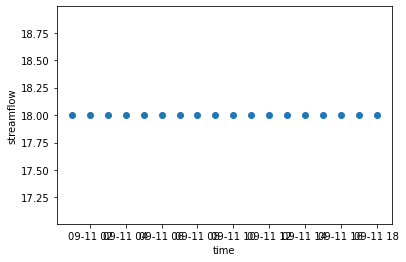

<IPython.core.display.Javascript object>

In [27]:
# Read parquet file
%time
#pip install pyarrow, fastparquet
import dask.dataframe as dd
data_1 = dd.read_parquet(
    "../data/parquet_all_feature_ids.gzip", engine='pyarrow', columns=['streamflow']
)
result_1=data_1.compute()
result_1.sort_index(inplace=True)
result_1=result_1.loc[(slice(None), [101]), :]
#result_1
r_xa_1 = result_1.to_xarray()
r_xa_1.plot.scatter("time", "streamflow")

### Query 1 feature id - Pandas

CPU times: user 11.3 s, sys: 3.3 s, total: 14.6 s
Wall time: 14.4 s


<AxesSubplot:xlabel='time', ylabel='streamflow'>

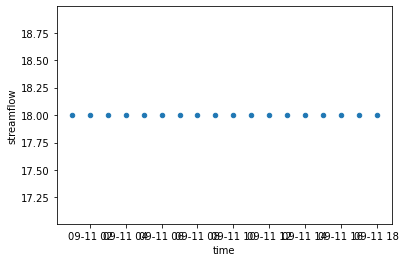

<IPython.core.display.Javascript object>

In [28]:
%%time

df_1 = pd.read_parquet("../data/parquet_all_feature_ids.gzip")
df_1=df_1.swaplevel()
df_1.sort_index(level=0, inplace=True)
result_1=df_1.loc[101]
#result_1
result_1.reset_index().plot.scatter('time','streamflow')

### Query 100 feature id - Dask

CPU times: user 31.3 s, sys: 6.58 s, total: 37.9 s
Wall time: 37.7 s


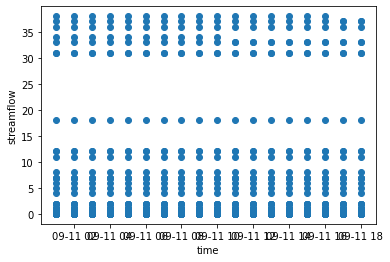

<IPython.core.display.Javascript object>

In [44]:
%%time
data_100 = dd.read_parquet(
    "../data/parquet_all_feature_ids.gzip", engine='pyarrow', columns=['streamflow']
)
result_100=data_100.compute()
result_100.sort_index(inplace=True)
result_100=result_100.loc[:, 100:1032, :]

r_xa_100 = result_100.to_xarray()
#r_xa
r_xa_100.plot.scatter("time", "streamflow")

### Query 100 feature id - Pandas

CPU times: user 11 s, sys: 3.3 s, total: 14.3 s
Wall time: 14 s


<AxesSubplot:xlabel='time', ylabel='streamflow'>

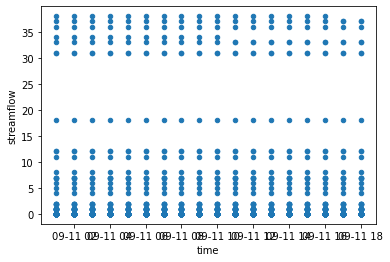

<IPython.core.display.Javascript object>

In [45]:
%%time

df_100 = pd.read_parquet("../data/parquet_all_feature_ids.gzip")
df_100=df_100.swaplevel()
df_100.sort_index(level=0, inplace=True)
result_100=df_100.loc[100:1032]
#result_100

result_100.reset_index().plot.scatter('time','streamflow')

### Query 10,000 feature_ids - Dask

CPU times: user 31.2 s, sys: 5.91 s, total: 37.2 s
Wall time: 37 s


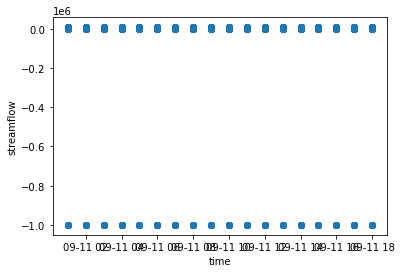

<IPython.core.display.Javascript object>

In [31]:
%%time
data_10000 = dd.read_parquet(
    "../data/parquet_all_feature_ids.gzip", engine='pyarrow', columns=['streamflow']
)
result_10000=data_10000.compute()
result_10000.sort_index(inplace=True)
result_10000=result_10000.loc[:, 100:252765, :]

r_xa_10000 = result_10000.to_xarray()
#r_xa
r_xa_10000.plot.scatter("time", "streamflow")

### Query 10,000 feature_ids - Pandas

CPU times: user 11 s, sys: 3.38 s, total: 14.4 s
Wall time: 14.2 s


<AxesSubplot:xlabel='time', ylabel='streamflow'>

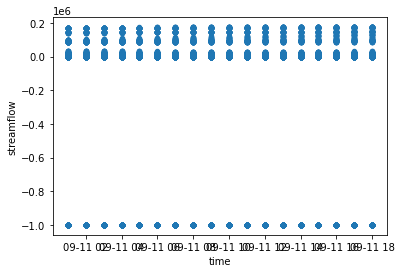

<IPython.core.display.Javascript object>

In [43]:
%%time

df_10000 = pd.read_parquet("../data/parquet_all_feature_ids.gzip")
df_10000=df_10000.swaplevel()
df_10000.sort_index(level=0, inplace=True)
result_10000=df_10000.loc[100:1122643]
result_10000.reset_index().plot.scatter('time','streamflow')

### Query 100,000 feature_ids - Dask

CPU times: user 32 s, sys: 5.84 s, total: 37.9 s
Wall time: 37.7 s


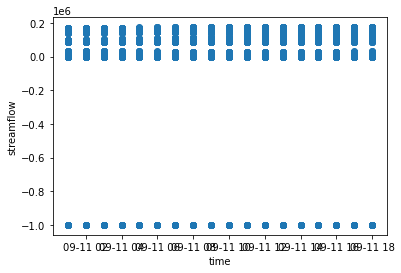

<IPython.core.display.Javascript object>

In [33]:
%%time
data_100000 = dd.read_parquet(
    "../data/parquet_all_feature_ids.gzip", engine='auto', columns=['streamflow']
)
result_100000=data_100000.compute()
result_100000.sort_index(inplace=True)
result_100000=result_100000.loc[:, 100:1122643, :]

r_xa_100000 = result_100000.to_xarray()
#r_xa
r_xa_100000.plot.scatter("time", "streamflow")

### Query 100,000 feature_ids - Pandas

CPU times: user 15.8 s, sys: 5.73 s, total: 21.6 s
Wall time: 21.4 s


<AxesSubplot:xlabel='time', ylabel='streamflow'>

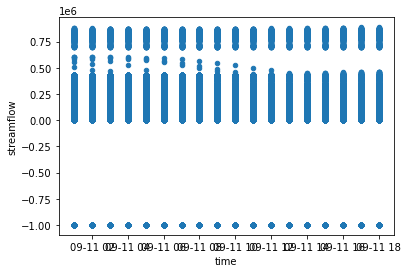

<IPython.core.display.Javascript object>

In [34]:
%%time

df_100000 = pd.read_parquet("../data/parquet_all_feature_ids.gzip")
df_100000=df_100000.swaplevel()
df_100000.sort_index(level=0, inplace=True)
result_100000=df_100000.loc[:]
result_100000.reset_index().plot.scatter('time','streamflow')